In [30]:
%pip install --upgrade yfinance==0.2.54
# %pip install plotly
# %pip install holidays


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: C:\Users\artik\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
# Load the necessary packages and modules
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import holidays
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")



In [32]:
# from curl_cffi import requests
# session = requests.Session(impersonate="chrome")

# ticker = "ADANIGREEN.NS"

# # Wait before retrying (Exponential backoff)

# data = yf.download(ticker, start="2021-06-01", end="2024-10-31", auto_adjust=True, session=session)
# data.to_csv(r"D:\Codes\Algo Trade\Stock Price Features\price_data_2.csv", index=True)
# print("Download Successful")
# data

data = pd.read_csv(r"D:\Codes\Algo Trade\Final Codes\Data\price_data_2.csv", )
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [33]:
print("Max date:", data['Date'].max())
print("Min date:", data['Date'].min())

data = data[data.Date <= '2024-10-31']

Max date: 2024-10-30 00:00:00
Min date: 2021-06-01 00:00:00


In [34]:
date_range = pd.DataFrame({'Date': pd.date_range(start='2021-06-01', end='2024-10-31')})
date_range['Weekday'] = date_range['Date'].dt.day_name()
data = date_range.merge(data, on='Date', how='left')
# Forward fill the missing values in all columns except 'Date' and 'Final_Sentiment'
for i in data.columns.difference(['Date']):
    data[i] = data[i].ffill()
data

,Date,Weekday,Close,High,Low,Open,Volume
0,2021-06-01,Tuesday,1271.050049,1280.000000,1249.000000,1270.000000,664012.0
1,2021-06-02,Wednesday,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0
2,2021-06-03,Thursday,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0
3,2021-06-04,Friday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0
4,2021-06-05,Saturday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0
...,...,...,...,...,...,...,...
1244,2024-10-27,Sunday,1644.000000,1718.900024,1625.000000,1700.000000,707626.0
1245,2024-10-28,Monday,1613.150024,1661.699951,1588.550049,1644.000000,850381.0
1246,2024-10-29,Tuesday,1635.099976,1641.000000,1588.000000,1612.000000,540217.0
1247,2024-10-30,Wednesday,1634.199951,1653.750000,1596.650024,1615.000000,713381.0


In [35]:
#PLOT CANDLE CHART FOR STOCK PRICE DATA
data['Date'] = pd.to_datetime(data['Date'])
monthly_data = data.resample('M', on='Date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})
monthly_data = monthly_data.dropna()
monthly_data = monthly_data.reset_index()

fig = go.Figure(data=[go.Candlestick(
    x=monthly_data['Date'],
    open=monthly_data['Open'],
    high=monthly_data['High'],
    low=monthly_data['Low'],
    close=monthly_data['Close']
)])

fig.update_xaxes(
    tickformat="%b %Y",
    tickmode="auto",
    nticks=30
)

fig.update_layout(
    title='Monthly Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

fig.show()

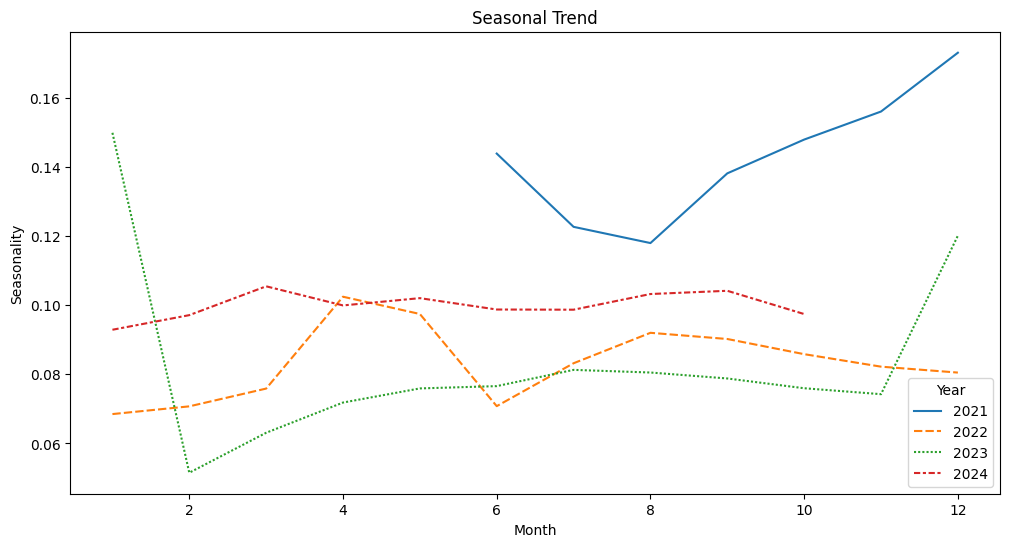

In [36]:
import seaborn as sns

# Extract month and year
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Group by month and year, then calculate the mean closing price
monthly_sum = data.groupby(['Year', 'Month'])['Close'].sum().reset_index()
yearly_sum = data.groupby(['Year'])['Close'].sum().reset_index()

seasonal_data = pd.merge(monthly_sum, yearly_sum, on='Year', suffixes=('', '_Year'))
seasonal_data['Seasonality'] = seasonal_data['Close'] / seasonal_data['Close_Year']

# Pivot the table to have months as columns and years as index
pivot_data = seasonal_data.pivot(index='Month', columns='Year', values='Seasonality')

plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_data)
plt.title('Seasonal Trend')
plt.xlabel('Month')
plt.ylabel('Seasonality')
plt.show()

In [37]:
pivot_data

Year,2021,2022,2023,2024
Month,,,,
1,NaN,0.068507,0.149937,0.092917
2,NaN,0.070742,0.051530,0.097148
3,NaN,0.075888,0.063096,0.105493
4,NaN,0.102479,0.071843,0.099958
5,NaN,0.097482,0.075933,0.102067
6,0.143918,0.070802,0.076601,0.098775
7,0.122708,0.083222,0.081302,0.098722
8,0.118012,0.092034,0.080537,0.103260
9,0.138191,0.090241,0.078814,0.104196


In [38]:
 #Simple Moving Average 
def SMA(data, ndays): 
    SMA = pd.Series(data['Close'].rolling(ndays).mean(), name = 'SMA') 
    data = data.join(SMA, rsuffix = '_SMA') 
    return data

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
    EMA = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA, rsuffix = '_EWMA') 
    return data

# Compute the Bollinger Bands 
def BBANDS(data, n):
    MA = data.Close.rolling(window=n).mean()
    SD = data.Close.rolling(window=n).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Returns RSI values
def rsi(close, periods = 14):
    close_delta = close.diff()
    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Returns the Force Index 
def ForceIndex(data, ndays): 
    FI = pd.Series(data['Close'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    data = data.join(FI) 
    return data

# Ease of Movement 
def EMV(data, ndays): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name = 'EMV') 
    data = data.join(EMV_MA) 
    return data 



In [39]:
close = data['Close']

# Compute the 50-day SMA
n = 50
smpl_mv = SMA(data,n)
data = smpl_mv.copy()
smpl_mv= smpl_mv.dropna()
smpl_mv = smpl_mv['SMA']

# Compute the 200-day EWMA
ew = 100
ex_mv = EWMA(data,ew)
data = ex_mv.copy()
ex_mv = ex_mv.dropna()
ex_mv = ex_mv['EWMA_100']

# Compute the Bollinger Bands for Google using the 50-day Moving average
n = 50
bollinger = BBANDS(data, n)
data = bollinger.copy()

# Call RSI function from the talib library to calculate RSI
data['RSI'] = rsi(data['Close'])


# Compute the Force Index 
n = 1
data['ForceIndex'] = ForceIndex(data,n)['ForceIndex']

# Compute the 14-day Ease of Movement for AAPL
n = 14
data['EMV'] = EMV(data, n)['EMV']







In [40]:
data

,Date,Weekday,Close,High,Low,Open,Volume,Month,Year,SMA,EWMA_100,MiddleBand,UpperBand,LowerBand,RSI,ForceIndex,EMV
0,2021-06-01,Tuesday,1271.050049,1280.000000,1249.000000,1270.000000,664012.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-02,Wednesday,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,3.972960e+07,NaN
2,2021-06-03,Thursday,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-1.536052e+07,NaN
3,2021-06-04,Friday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-8.130300e+06,NaN
4,2021-06-05,Saturday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2024-10-27,Sunday,1644.000000,1718.900024,1625.000000,1700.000000,707626.0,10,2024,1837.941990,1818.335785,1837.941990,2074.059625,1601.824354,23.819444,0.000000e+00,-86222.087290
1245,2024-10-28,Monday,1613.150024,1661.699951,1588.550049,1644.000000,850381.0,10,2024,1832.938989,1814.272701,1832.938989,2077.319628,1588.558351,20.775807,-2.623423e+07,-113247.662982
1246,2024-10-29,Tuesday,1635.099976,1641.000000,1588.000000,1612.000000,540217.0,10,2024,1828.325989,1810.724726,1828.325989,2078.810084,1577.841893,27.840868,1.185774e+07,-107880.123880
1247,2024-10-30,Wednesday,1634.199951,1653.750000,1596.650024,1615.000000,713381.0,10,2024,1824.015989,1807.229186,1824.015989,2080.346806,1567.685172,27.731664,-6.420607e+05,-95664.234585


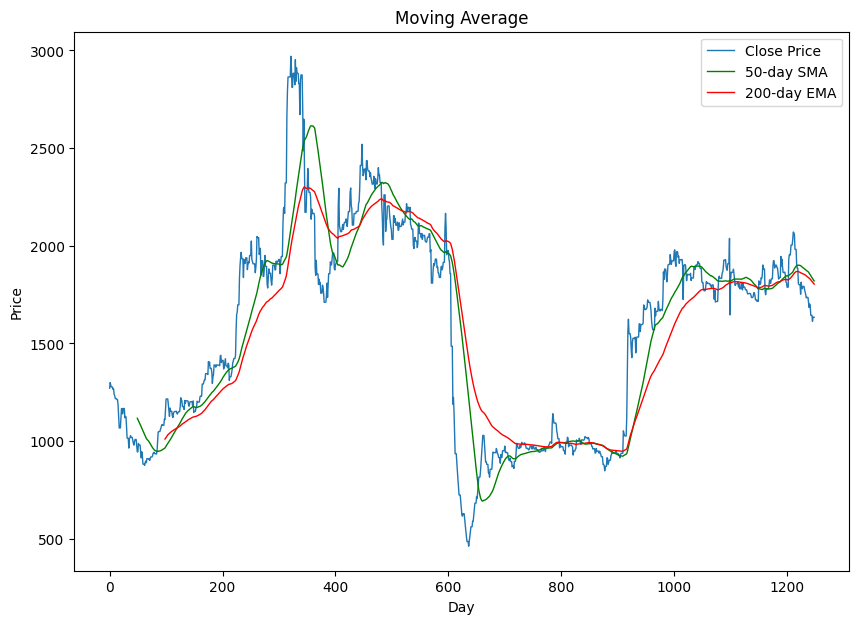

In [41]:
# Plotting the Adani stock Price Series chart and Moving Averages below
plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Moving Average')
plt.xlabel('Day')
plt.ylabel('Price')

# Plot close price and moving averages
plt.plot(data['Close'],lw=1, label='Close Price')
plt.plot(smpl_mv,'g',lw=1, label='50-day SMA')
plt.plot(ex_mv,'r', lw=1, label='200-day EMA')

# Add a legend to the axis
plt.legend()

plt.show()

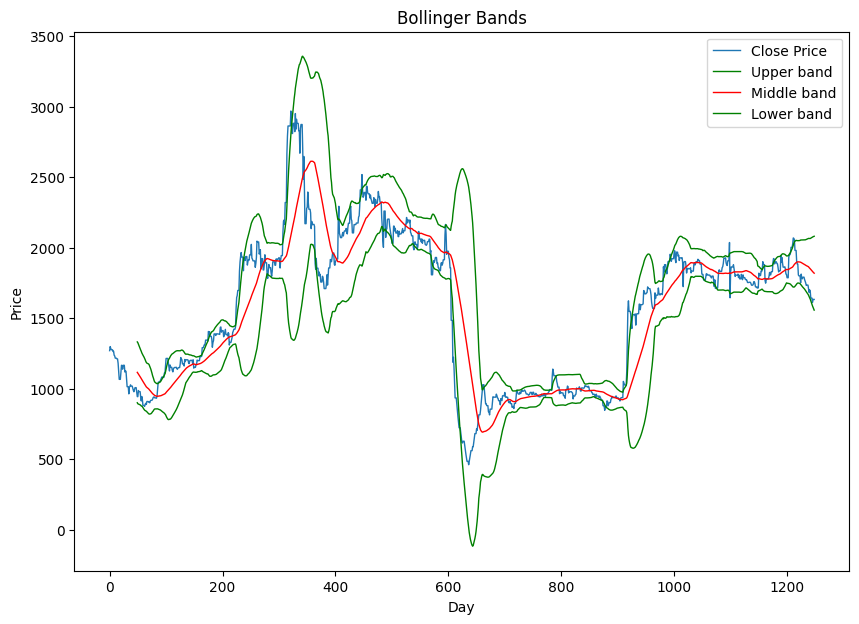

In [42]:
# Create the plot

plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Bollinger Bands')
plt.xlabel('Day')
plt.ylabel('Price')

plt.plot(bollinger.Close,lw=1, label='Close Price')
plt.plot(data['UpperBand'],'g',lw=1, label='Upper band')
plt.plot(data['MiddleBand'],'r',lw=1, label='Middle band')
plt.plot(data['LowerBand'],'g', lw=1, label='Lower band')

# Add a legend to the axis
plt.legend()

plt.show()

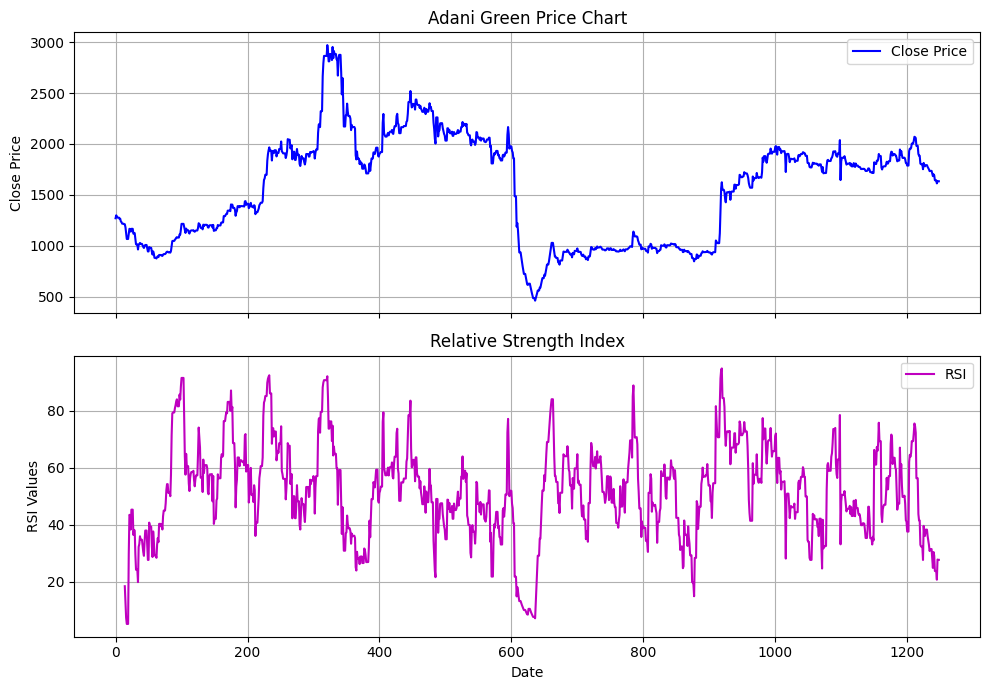

In [43]:
import matplotlib.pyplot as plt

# Creating the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), sharex=True)

# Price Series Chart
axes[0].plot(data['Close'], label='Close Price', color='b')
axes[0].set_title('Adani Green Price Chart')
axes[0].set_ylabel('Close Price')
axes[0].legend()
axes[0].grid(True)

# RSI Chart
axes[1].plot(data['RSI'], label='RSI', color='m')
axes[1].set_title('Relative Strength Index')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('RSI Values')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [44]:
data

,Date,Weekday,Close,High,Low,Open,Volume,Month,Year,SMA,EWMA_100,MiddleBand,UpperBand,LowerBand,RSI,ForceIndex,EMV
0,2021-06-01,Tuesday,1271.050049,1280.000000,1249.000000,1270.000000,664012.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-02,Wednesday,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,3.972960e+07,NaN
2,2021-06-03,Thursday,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-1.536052e+07,NaN
3,2021-06-04,Friday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-8.130300e+06,NaN
4,2021-06-05,Saturday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2024-10-27,Sunday,1644.000000,1718.900024,1625.000000,1700.000000,707626.0,10,2024,1837.941990,1818.335785,1837.941990,2074.059625,1601.824354,23.819444,0.000000e+00,-86222.087290
1245,2024-10-28,Monday,1613.150024,1661.699951,1588.550049,1644.000000,850381.0,10,2024,1832.938989,1814.272701,1832.938989,2077.319628,1588.558351,20.775807,-2.623423e+07,-113247.662982
1246,2024-10-29,Tuesday,1635.099976,1641.000000,1588.000000,1612.000000,540217.0,10,2024,1828.325989,1810.724726,1828.325989,2078.810084,1577.841893,27.840868,1.185774e+07,-107880.123880
1247,2024-10-30,Wednesday,1634.199951,1653.750000,1596.650024,1615.000000,713381.0,10,2024,1824.015989,1807.229186,1824.015989,2080.346806,1567.685172,27.731664,-6.420607e+05,-95664.234585


### Adding Sentiment Score using multiple methods

In [45]:
#read news feature
news=  pd.read_excel(r"D:\Codes\Algo Trade\Final Codes\Data\FinBERT_Results.xlsx", sheet_name='Raw')
news['Date'] = pd.to_datetime(news['Date'], format='%Y-%m-%d')

In [46]:
news.shape

(1673, 6)

In [47]:
def remove_outliers(df, confidence_column):

    def is_outlier(s):
        lower_threshold = s.quantile(0.25)
        upper_threshold = s.quantile(0.75)
        return ~s.between(lower_threshold, upper_threshold)

    df_filtered = df.groupby('Date').apply(lambda x: x[~is_outlier(x[confidence_column])])
    df_filtered = df_filtered.reset_index(drop=True)
    return df_filtered

# Apply outlier removal for Positive sentiment
news_positive = news[news['sentiment_label'] == 'Positive'].copy()
# news_positive = remove_outliers(news_positive, 'confidence_score')

# Apply outlier removal for Negative sentiment
news_negative = news[news['sentiment_label'] == 'Negative'].copy()
# news_negative = remove_outliers(news_negative, 'confidence_score')

# Apply outlier removal for Neutral sentiment
news_neutral = news[news['sentiment_label'] == 'Neutral'].copy()
# news_neutral = remove_outliers(news_neutral, 'confidence_score')

# Combine the filtered dataframes
news_filtered = pd.concat([news_positive, news_negative, news_neutral])

# Create the 'final_sentiment' DataFrame
final_sentiment = pd.DataFrame(data['Date'].unique(), columns=['Date'])


In [48]:
news.shape

(1673, 6)

In [49]:
news = news_filtered.copy(deep = True)

In [50]:
#METHOD_2 : Select category having max of confidence score on each date
#----------------------------------------------------------------------------------------------------------------------------------------------
# Creating the pivot table with max values
sent_score = news.pivot_table(index='Date', columns='sentiment_label', values='confidence_score', aggfunc='max').reset_index()


# Function to get the sentiment score of the category with the lowest non-zero variance
def get_cat_func_score(row):
    non_zero_max = row[['Positive', 'Negative', 'Neutral']]
    max_col = non_zero_max.idxmax()
    return max_col  # Return the sentiment name of the selected category

# Apply function to get the desired sentiment scores
sent_score['Final_sentiment_Max_Max'] = sent_score.apply(get_cat_func_score, axis=1)
final_sentiment = final_sentiment.merge(sent_score[['Date', 'Final_sentiment_Max_Max']], on='Date', how='left')


#----------------------------------------------------------------------------------------------------------------------------------------------
# Creating the pivot table with min values
sent_score = news.pivot_table(index='Date', columns='sentiment_label', values='confidence_score', aggfunc='min').reset_index()

# Function to get the sentiment score of the category with the lowest non-zero variance
def get_cat_func_score(row):
    non_zero_max = row[['Positive', 'Negative', 'Neutral']]
    max_col = non_zero_max.idxmax()
    return max_col  # Return the sentiment name of the selected category

# Apply function to get the desired sentiment scores
sent_score['Final_sentiment_Max_Min'] = sent_score.apply(get_cat_func_score, axis=1)
final_sentiment = final_sentiment.merge(sent_score[['Date', 'Final_sentiment_Max_Min']], on='Date', how='left')

#----------------------------------------------------------------------------------------------------------------------------------------------
# Creating the pivot table with avg values
sent_score = news.pivot_table(index='Date', columns='sentiment_label', values='confidence_score', aggfunc='mean').reset_index()

# Function to get the sentiment score of the category with the lowest non-zero variance
def get_cat_func_score(row):
    non_zero_max = row[['Positive', 'Negative', 'Neutral']]
    max_col = non_zero_max.idxmax()
    return max_col  # Return the sentiment name of the selected category

# Apply function to get the desired sentiment scores
sent_score['Final_sentiment_Max_Mean'] = sent_score.apply(get_cat_func_score, axis=1)
final_sentiment = final_sentiment.merge(sent_score[['Date', 'Final_sentiment_Max_Mean']], on='Date', how='left')



In [51]:
data1= data.merge(final_sentiment, on='Date', how='outer')
data1

,Date,Weekday,Close,High,Low,Open,Volume,Month,Year,SMA,EWMA_100,MiddleBand,UpperBand,LowerBand,RSI,ForceIndex,EMV,Final_sentiment_Max_Max,Final_sentiment_Max_Min,Final_sentiment_Max_Mean
0,2021-06-01,Tuesday,1271.050049,1280.000000,1249.000000,1270.000000,664012.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-02,Wednesday,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,3.972960e+07,NaN,NaN,NaN,NaN
2,2021-06-03,Thursday,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-1.536052e+07,NaN,NaN,NaN,NaN
3,2021-06-04,Friday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-8.130300e+06,NaN,NaN,NaN,NaN
4,2021-06-05,Saturday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2024-10-27,Sunday,1644.000000,1718.900024,1625.000000,1700.000000,707626.0,10,2024,1837.941990,1818.335785,1837.941990,2074.059625,1601.824354,23.819444,0.000000e+00,-86222.087290,Neutral,Neutral,Neutral
1245,2024-10-28,Monday,1613.150024,1661.699951,1588.550049,1644.000000,850381.0,10,2024,1832.938989,1814.272701,1832.938989,2077.319628,1588.558351,20.775807,-2.623423e+07,-113247.662982,Negative,Neutral,Negative
1246,2024-10-29,Tuesday,1635.099976,1641.000000,1588.000000,1612.000000,540217.0,10,2024,1828.325989,1810.724726,1828.325989,2078.810084,1577.841893,27.840868,1.185774e+07,-107880.123880,Negative,Negative,Negative
1247,2024-10-30,Wednesday,1634.199951,1653.750000,1596.650024,1615.000000,713381.0,10,2024,1824.015989,1807.229186,1824.015989,2080.346806,1567.685172,27.731664,-6.420607e+05,-95664.234585,Positive,Positive,Positive


In [52]:
data1.loc[:, data1.filter(like='Final_sentiment').columns] = data1.filter(like='Final_sentiment').fillna('Neutral')


# Forward fill the missing values in all columns except 'Date' and 'Final_Sentiment'
for i in data1.columns.difference(['Date', 'Final_Sentiment']):
    data1[i] = data1[i].ffill()


In [53]:
sentiment_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}

# Apply the mapping to all sentiment columns
sentiment_columns = data1.filter(like='Final_sentiment').columns
for col in sentiment_columns:
    data1[col] = data1[col].map(sentiment_mapping)

data1

,Date,Weekday,Close,High,Low,Open,Volume,Month,Year,SMA,EWMA_100,MiddleBand,UpperBand,LowerBand,RSI,ForceIndex,EMV,Final_sentiment_Max_Max,Final_sentiment_Max_Min,Final_sentiment_Max_Mean
0,2021-06-01,Tuesday,1271.050049,1280.000000,1249.000000,1270.000000,664012.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2021-06-02,Wednesday,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,3.972960e+07,NaN,0,0,0
2,2021-06-03,Thursday,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-1.536052e+07,NaN,0,0,0
3,2021-06-04,Friday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,-8.130300e+06,NaN,0,0,0
4,2021-06-05,Saturday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2024-10-27,Sunday,1644.000000,1718.900024,1625.000000,1700.000000,707626.0,10,2024,1837.941990,1818.335785,1837.941990,2074.059625,1601.824354,23.819444,0.000000e+00,-86222.087290,0,0,0
1245,2024-10-28,Monday,1613.150024,1661.699951,1588.550049,1644.000000,850381.0,10,2024,1832.938989,1814.272701,1832.938989,2077.319628,1588.558351,20.775807,-2.623423e+07,-113247.662982,-1,0,-1
1246,2024-10-29,Tuesday,1635.099976,1641.000000,1588.000000,1612.000000,540217.0,10,2024,1828.325989,1810.724726,1828.325989,2078.810084,1577.841893,27.840868,1.185774e+07,-107880.123880,-1,-1,-1
1247,2024-10-30,Wednesday,1634.199951,1653.750000,1596.650024,1615.000000,713381.0,10,2024,1824.015989,1807.229186,1824.015989,2080.346806,1567.685172,27.731664,-6.420607e+05,-95664.234585,1,1,1


### Adding Holidays

In [54]:

headers = {
    'Accept': 'application/json',
    'Authorization': 'Bearer YOUR_API_KEY'  # Add API key if required
}


def holiday_fetcher(x):
    # Fetching holidays data from Upstox API
    url = "https://api.upstox.com/v2/market/holidays/{}".format(x)  # Removed ':date'
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        try:
           return response.json()['data'][0]['holiday_type']
        except:
            return None 
    else:
        print(f"Error {response.status_code}: {response.text}")

data1['Exchange_Holiday'] = data1['Date'].apply(lambda x: holiday_fetcher(x.strftime('%Y-%m-%d')))


data1

,Date,Weekday,Close,High,Low,Open,Volume,Month,Year,SMA,...,MiddleBand,UpperBand,LowerBand,RSI,ForceIndex,EMV,Final_sentiment_Max_Max,Final_sentiment_Max_Min,Final_sentiment_Max_Mean,Exchange_Holiday
0,2021-06-01,Tuesday,1271.050049,1280.000000,1249.000000,1270.000000,664012.0,6,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,None
1,2021-06-02,Wednesday,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0,6,2021,NaN,...,NaN,NaN,NaN,NaN,3.972960e+07,NaN,0,0,0,None
2,2021-06-03,Thursday,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0,6,2021,NaN,...,NaN,NaN,NaN,NaN,-1.536052e+07,NaN,0,0,0,None
3,2021-06-04,Friday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,...,NaN,NaN,NaN,NaN,-8.130300e+06,NaN,0,0,0,None
4,2021-06-05,Saturday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2024-10-27,Sunday,1644.000000,1718.900024,1625.000000,1700.000000,707626.0,10,2024,1837.941990,...,1837.941990,2074.059625,1601.824354,23.819444,0.000000e+00,-86222.087290,0,0,0,None
1245,2024-10-28,Monday,1613.150024,1661.699951,1588.550049,1644.000000,850381.0,10,2024,1832.938989,...,1832.938989,2077.319628,1588.558351,20.775807,-2.623423e+07,-113247.662982,-1,0,-1,None
1246,2024-10-29,Tuesday,1635.099976,1641.000000,1588.000000,1612.000000,540217.0,10,2024,1828.325989,...,1828.325989,2078.810084,1577.841893,27.840868,1.185774e+07,-107880.123880,-1,-1,-1,None
1247,2024-10-30,Wednesday,1634.199951,1653.750000,1596.650024,1615.000000,713381.0,10,2024,1824.015989,...,1824.015989,2080.346806,1567.685172,27.731664,-6.420607e+05,-95664.234585,1,1,1,None


In [55]:

# Get Indian holidays for a specific year
india_holidays = holidays.country_holidays('IN', years=[2022, 2023, 2024, 2025])

data1['India_Holidays'] = data1['Date'].apply(lambda x: 1 if x in india_holidays else 0)
data1

,Date,Weekday,Close,High,Low,Open,Volume,Month,Year,SMA,...,UpperBand,LowerBand,RSI,ForceIndex,EMV,Final_sentiment_Max_Max,Final_sentiment_Max_Min,Final_sentiment_Max_Mean,Exchange_Holiday,India_Holidays
0,2021-06-01,Tuesday,1271.050049,1280.000000,1249.000000,1270.000000,664012.0,6,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,None,0
1,2021-06-02,Wednesday,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0,6,2021,NaN,...,NaN,NaN,NaN,3.972960e+07,NaN,0,0,0,None,0
2,2021-06-03,Thursday,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0,6,2021,NaN,...,NaN,NaN,NaN,-1.536052e+07,NaN,0,0,0,None,0
3,2021-06-04,Friday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,...,NaN,NaN,NaN,-8.130300e+06,NaN,0,0,0,None,0
4,2021-06-05,Saturday,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,...,NaN,NaN,NaN,0.000000e+00,NaN,0,0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2024-10-27,Sunday,1644.000000,1718.900024,1625.000000,1700.000000,707626.0,10,2024,1837.941990,...,2074.059625,1601.824354,23.819444,0.000000e+00,-86222.087290,0,0,0,None,0
1245,2024-10-28,Monday,1613.150024,1661.699951,1588.550049,1644.000000,850381.0,10,2024,1832.938989,...,2077.319628,1588.558351,20.775807,-2.623423e+07,-113247.662982,-1,0,-1,None,0
1246,2024-10-29,Tuesday,1635.099976,1641.000000,1588.000000,1612.000000,540217.0,10,2024,1828.325989,...,2078.810084,1577.841893,27.840868,1.185774e+07,-107880.123880,-1,-1,-1,None,0
1247,2024-10-30,Wednesday,1634.199951,1653.750000,1596.650024,1615.000000,713381.0,10,2024,1824.015989,...,2080.346806,1567.685172,27.731664,-6.420607e+05,-95664.234585,1,1,1,None,0


In [56]:
#ONE HOT ENCODING OF CARTEGORICAL VARIABLES
data1 = pd.concat([data1, pd.get_dummies(data1['Exchange_Holiday'],prefix = 'Exchange_holidays')], axis=1).drop(columns=['Exchange_Holiday'], axis = 1)
data1 = pd.concat([data1, pd.get_dummies(data1['Weekday'])], axis=1).drop(columns=['Weekday'], axis = 1)
data1  =data1.sort_values(by='Date', ascending=True)
data1

,Date,Close,High,Low,Open,Volume,Month,Year,SMA,EWMA_100,...,India_Holidays,Exchange_holidays_SETTLEMENT_HOLIDAY,Exchange_holidays_TRADING_HOLIDAY,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2021-06-01,1271.050049,1280.000000,1249.000000,1270.000000,664012.0,6,2021,NaN,NaN,...,0,False,False,False,False,False,False,False,True,False
1,2021-06-02,1299.800049,1318.449951,1275.000000,1275.000000,1381899.0,6,2021,NaN,NaN,...,0,False,False,False,False,False,False,False,False,True
2,2021-06-03,1286.900024,1323.000000,1281.099976,1323.000000,1190736.0,6,2021,NaN,NaN,...,0,False,False,False,False,False,False,True,False,False
3,2021-06-04,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,...,0,False,False,True,False,False,False,False,False,False
4,2021-06-05,1277.250000,1308.000000,1271.250000,1305.199951,842516.0,6,2021,NaN,NaN,...,0,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2024-10-27,1644.000000,1718.900024,1625.000000,1700.000000,707626.0,10,2024,1837.941990,1818.335785,...,0,False,False,False,False,False,True,False,False,False
1245,2024-10-28,1613.150024,1661.699951,1588.550049,1644.000000,850381.0,10,2024,1832.938989,1814.272701,...,0,False,False,False,True,False,False,False,False,False
1246,2024-10-29,1635.099976,1641.000000,1588.000000,1612.000000,540217.0,10,2024,1828.325989,1810.724726,...,0,False,False,False,False,False,False,False,True,False
1247,2024-10-30,1634.199951,1653.750000,1596.650024,1615.000000,713381.0,10,2024,1824.015989,1807.229186,...,0,False,False,False,False,False,False,False,False,True


In [57]:
data1.isna().any()

Date                                    False
Close                                   False
High                                    False
Low                                     False
Open                                    False
Volume                                  False
Month                                   False
Year                                    False
SMA                                      True
EWMA_100                                 True
MiddleBand                               True
UpperBand                                True
LowerBand                                True
RSI                                      True
ForceIndex                               True
EMV                                      True
Final_sentiment_Max_Max                 False
Final_sentiment_Max_Min                 False
Final_sentiment_Max_Mean                False
India_Holidays                          False
Exchange_holidays_SETTLEMENT_HOLIDAY    False
Exchange_holidays_TRADING_HOLIDAY 

In [58]:
data1.to_csv(r"D:\Codes\Algo Trade\Final Codes\Data\final_data_4.csv", index = False)
data1 = pd.read_csv(r"D:\Codes\Algo Trade\Final Codes\Data\final_data_4.csv", )